## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the Norway dataset. B. part is transfer learning with Swiss/GLAMOS train set and Norway test set

### Setting Up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 32
Number of winter, summer and annual samples: 6275
Number of annual samples: 3184
Number of winter samples: 3091
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='NOR_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-06-17 12:58:07,139 - INFO - Number of annual and seasonal samples: 6275
2025-06-17 12:58:07,143 - INFO - Running on 32 glaciers:
['Langfjordjoekulen' 'Rundvassbreen' 'Engabreen' 'Aalfotbreen'
 'Hansebreen' 'Nigardsbreen' 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen'
 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memurubreen'
 'Vestre Memurubreen' 'Hoegtuvbreen' 'Bondhusbrea']
2025-06-17 12:58:07,171 - INFO - Number of annual samples: 3184
2025-06-17 12:58:07,173 - INFO - Number of winter samples: 3091
2025-06-17 12:58:07,174 - INFO - Adding climate features...
2025-06-17 12:58:33,445 - INFO - Converting to monthly resolution...
2025-06-17 12:58:48,344 - INFO - Number of monthly rows: 60056
2025-06-17 

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2013   21.77702   70.12589          -4.92        341.344485   
1  2013   21.77702   70.12589          -4.92        341.344485   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            129.655515              471  RGI60-08.01258   
1            129.655515              471  RGI60-08.01258   

                                            POINT_ID  ID  ...  \
0  Langfjordjoekulen_2013_annual_70.12589_21.7770...   0  ...   
1  Langfjordjoekulen_2013_annual_70.12589_21.7770...   0  ...   

   consensus_ice_thickness       t2m        tp      slhf      sshf       ssrd  \
0                96.980293 -0.428070  0.003846  -55354.0  657502.0  2040907.0   
1                96.980293 -4.780853  0.003902  178386.0  909366.0   157664.0   

        fal        str       u10       v10  
0  0.439741 -2504336.0 -0.141248  0.397857  
1  0.817481 -1714196.0 -0.183276  1.758524  

[2 rows x 27 columns]

#### A.2. Dataset statistics

In [ ]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

In [ ]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)


In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Aalfotbreen') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

In [ ]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:

###### Either run A.3.1. or A.3.2.

##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

###### This test set is the same used in the Norway paper

In [5]:
## find RGIId of Glaciers Kamilla used as test set

glacier_list_df = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw +'glaciological_point_mass_balance_Norway.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')

# breid ids that Kamilla used as test set
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]


breid_to_rgiid = {}
for breid in breid_list:
    matching_row = glacier_list_df[glacier_list_df['breid'] == breid]
    rgiid = matching_row['rgiid'].iloc[0]
    breid_to_rgiid[breid] = rgiid


# Display the mapping
print("Mapping from breid to RGI ID:")
for breid, rgiid in breid_to_rgiid.items():
    print(f"{breid}: {rgiid}")

# Create a list of just the RGI IDs for easy use
test_rgiids = list(breid_to_rgiid.values())
print("\nList of test RGI IDs:")
print(test_rgiids)

rgi_to_glacier = {}

for rgi_id in test_rgiids:
    matching_rows = data_NOR[data_NOR['RGIId'] == rgi_id]
    glacier_name = matching_rows['GLACIER'].iloc[0]
    rgi_to_glacier[rgi_id] = glacier_name


print("RGI ID to Glacier Name mapping:")
for rgi_id, glacier_name in rgi_to_glacier.items():
    print(f"{rgi_id}: {glacier_name}")

norway_kamilla_glacierlist = list(rgi_to_glacier.values())
print("\nList of test RGI IDs:")
print(norway_kamilla_glacierlist)

Mapping from breid to RGI ID:
54: RGI60-08.01258
703: RGI60-08.01026
941: RGI60-08.02384
1135: RGI60-08.01598
1280: RGI60-08.01484
2085: RGI60-08.02650
2320: RGI60-08.00434
2478: RGI60-08.01286
2768: RGI60-08.00449
2769: RGI60-08.01013
3133: RGI60-08.02916
3137: RGI60-08.02918
3138: RGI60-08.02920
3141: RGI60-08.02969

List of test RGI IDs:
['RGI60-08.01258', 'RGI60-08.01026', 'RGI60-08.02384', 'RGI60-08.01598', 'RGI60-08.01484', 'RGI60-08.02650', 'RGI60-08.00434', 'RGI60-08.01286', 'RGI60-08.00449', 'RGI60-08.01013', 'RGI60-08.02916', 'RGI60-08.02918', 'RGI60-08.02920', 'RGI60-08.02969']
RGI ID to Glacier Name mapping:
RGI60-08.01258: Langfjordjoekulen
RGI60-08.01026: Cainhavarre
RGI60-08.02384: Rundvassbreen
RGI60-08.01598: Svartisheibreen
RGI60-08.01484: Trollbergdalsbreen
RGI60-08.02650: Hansebreen
RGI60-08.00434: Tunsbergdalsbreen
RGI60-08.01286: Austdalsbreen
RGI60-08.00449: Hellstugubreen
RGI60-08.01013: Austre Memurubreen
RGI60-08.02916: Bondhusbrea
RGI60-08.02918: Svelgjabreen

In [6]:
"""
test_glaciers = [
    'Vestre Memurubreen', 'Rembesdalskaaka',
    'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
    'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
    'Blomstoelskardsbreen'
]
"""
test_glaciers = norway_kamilla_glacierlist.copy()

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 17288
Size of train data: 42768
Percentage of test size: 40.42%
Train glaciers: (18) ['Engabreen' 'Aalfotbreen' 'Nigardsbreen' 'Juvfonne' 'Rembesdalskaaka'
 'Storsteinsfjellbreen' 'Vetlefjordbreen' 'Harbardsbreen'
 'Storglombreen N' 'Graafjellsbrea' 'Breidablikkbrea' 'Graasubreen'
 'Blaaisen' 'Blabreen' 'Ruklebreen' 'Vesledalsbreen' 'Vestre Memurubreen'
 'Hoegtuvbreen']
Test glaciers: (14) ['Langfjordjoekulen' 'Rundvassbreen' 'Hansebreen' 'Austdalsbreen'
 'Hellstugubreen' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Svartisheibreen' 'Trollbergdalsbreen' 'Cainhavarre' 'Tunsbergdalsbreen'
 'Austre Memurubreen' 'Bondhusbrea']


##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.3. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### A.4. XGBoost:

In [7]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'gpu_hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 1

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

###### Grid search:

In [8]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Norway_Kamilla_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Norway_Kamilla_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (42768, 25)
Shape of testing dataset: (17288, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}
Best score:
 -0.2639033345987551
Shape of the test: (17288, 14)
Overall score: 0.7087236288862115
CPU times: user 296 ms, sys: 154 ms, total: 450 ms
Wall time: 246 ms


learning_rate  max_depth  n_estimators  Validation rmse  Train rmse
Model                                                                     
1               0.10          6           500         0.263903    0.006160
2               0.10          6           400         0.268012    0.008634
3               0.10          5           700         0.269064    0.009441
4               0.10          7           700         0.273689    0.002029
5               0.10          7           400         0.277916    0.003762
6               0.10          5           400         0.286236    0.020303
7               0.10          6           200         0.289546    0.022217
8               0.10          8           700         0.316781    0.001681
9               0.10          4           500         0.321668    0.038510
10              0.01          8           500         0.357873    0.031924

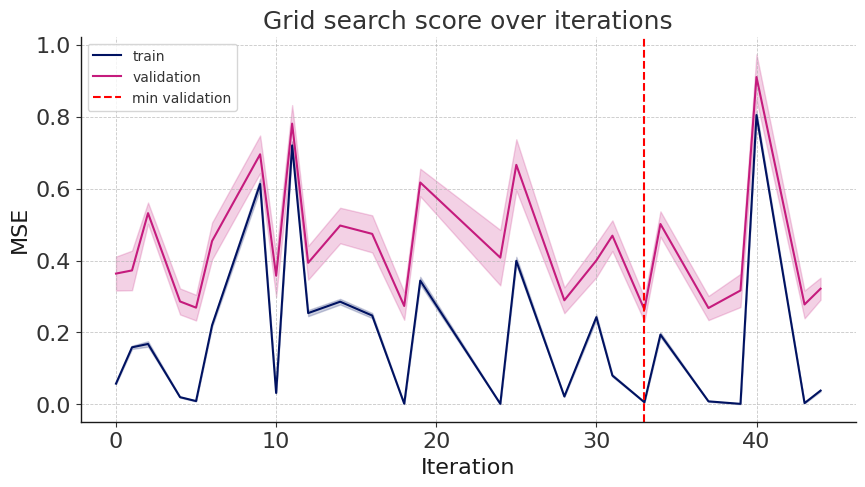

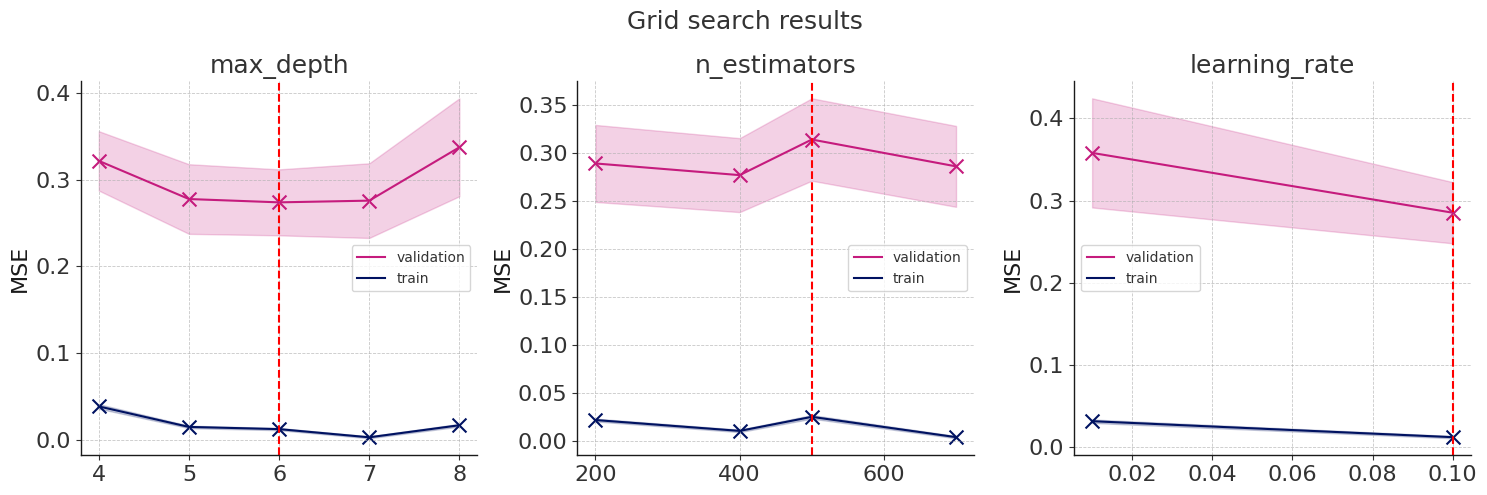

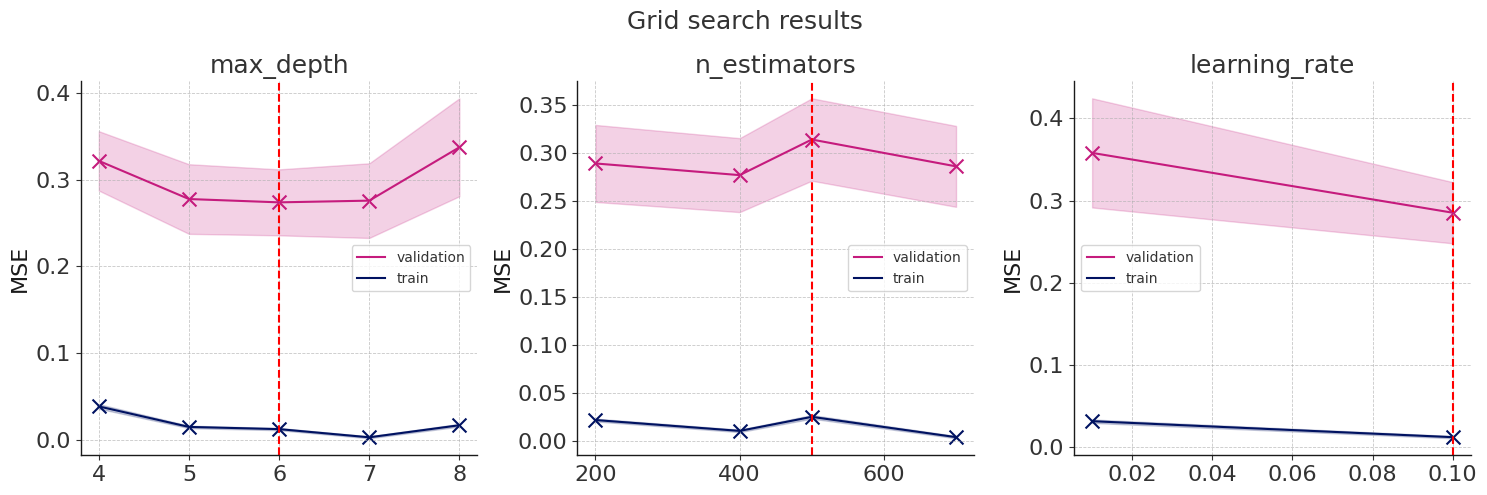

In [9]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

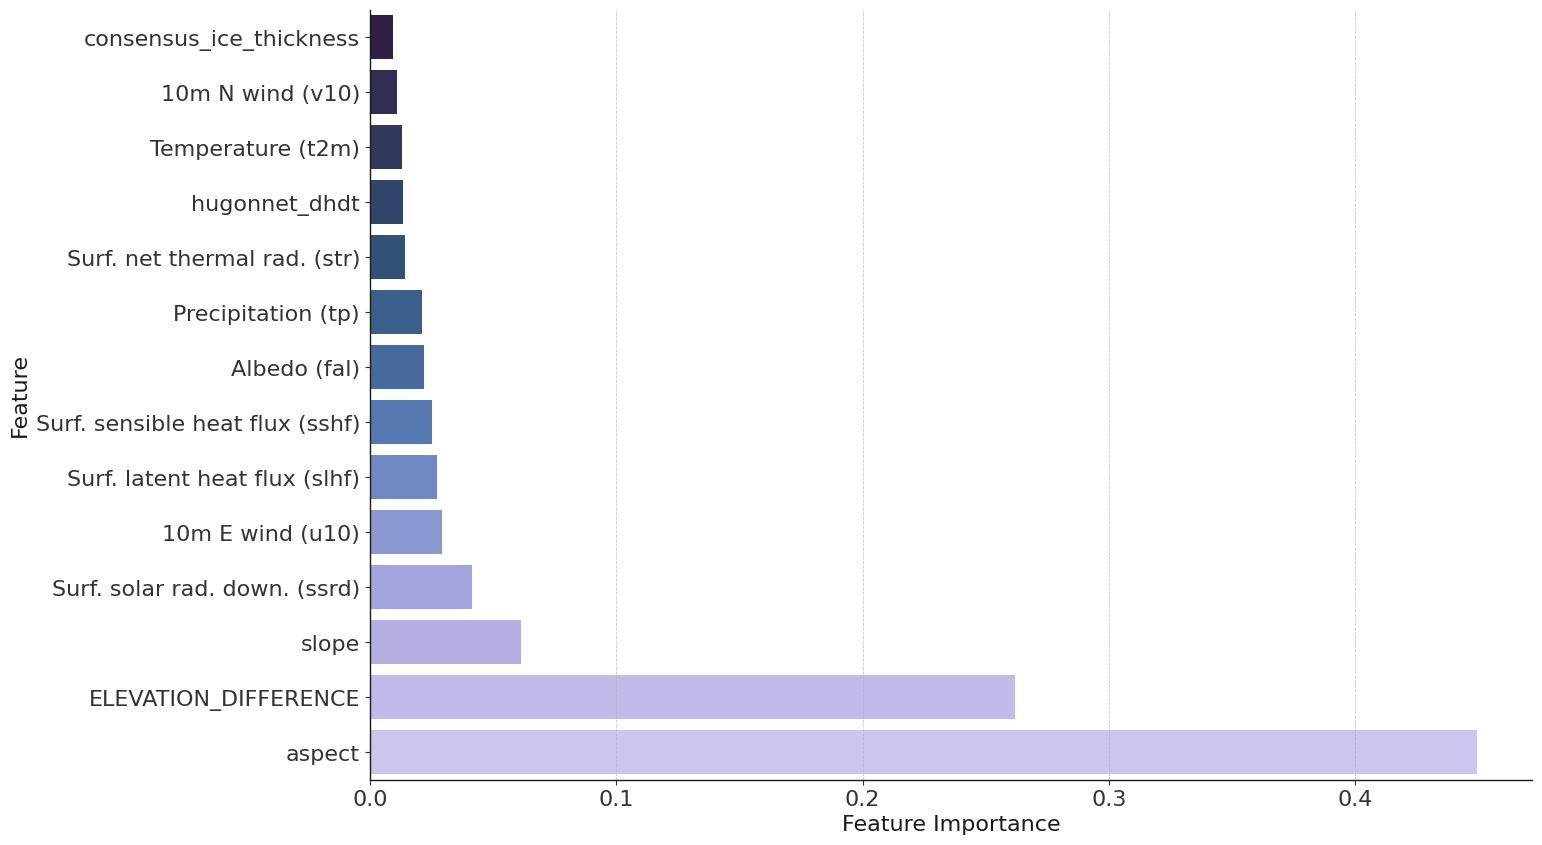

In [10]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (17288, 14)


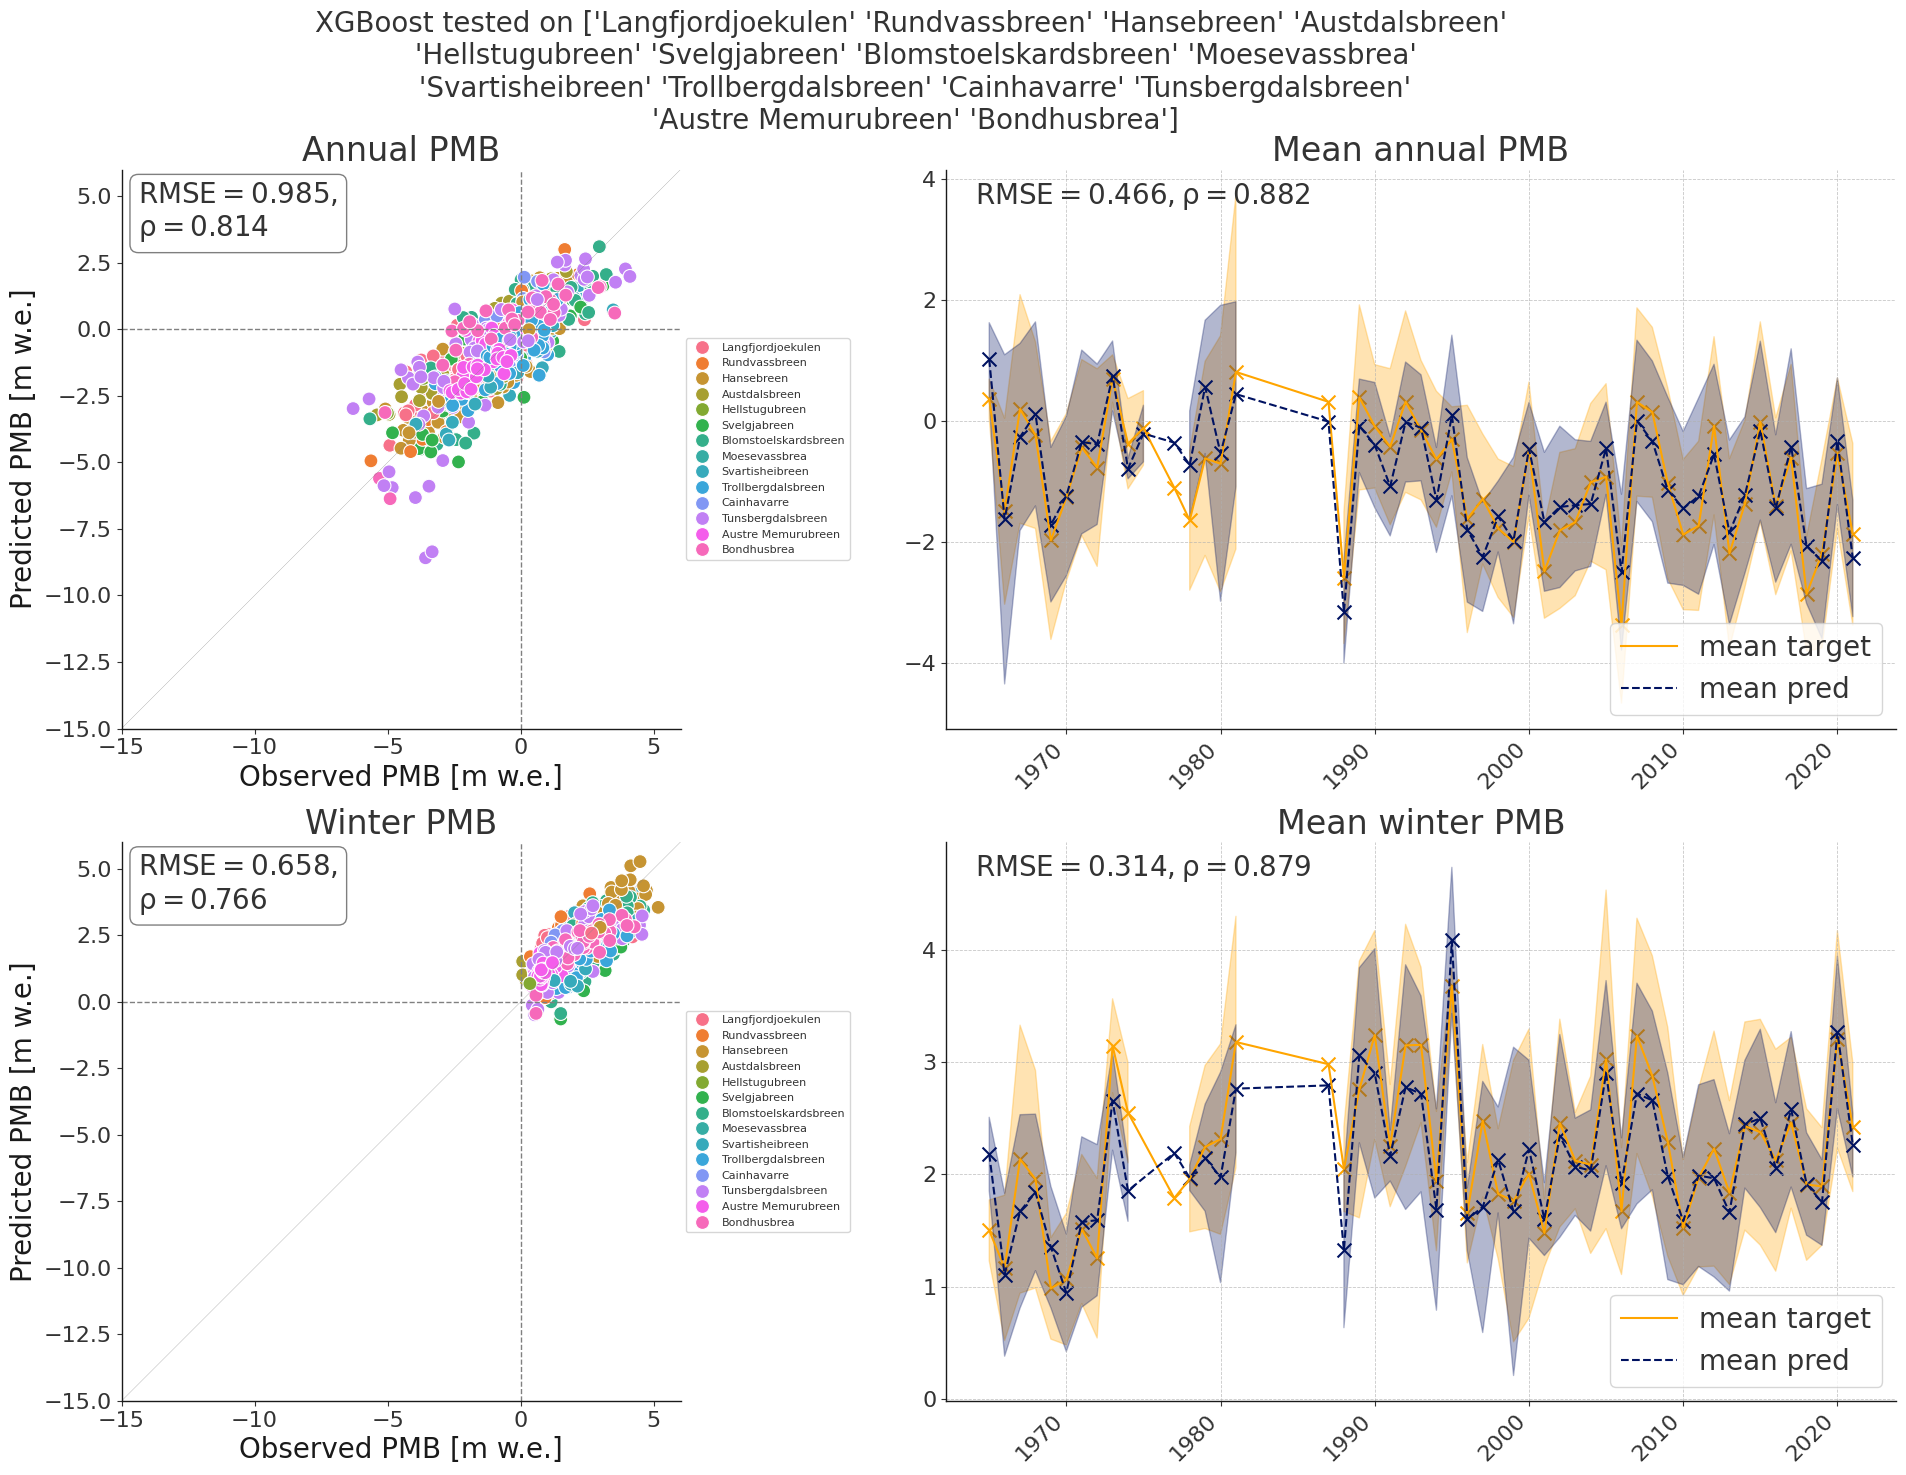

In [11]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

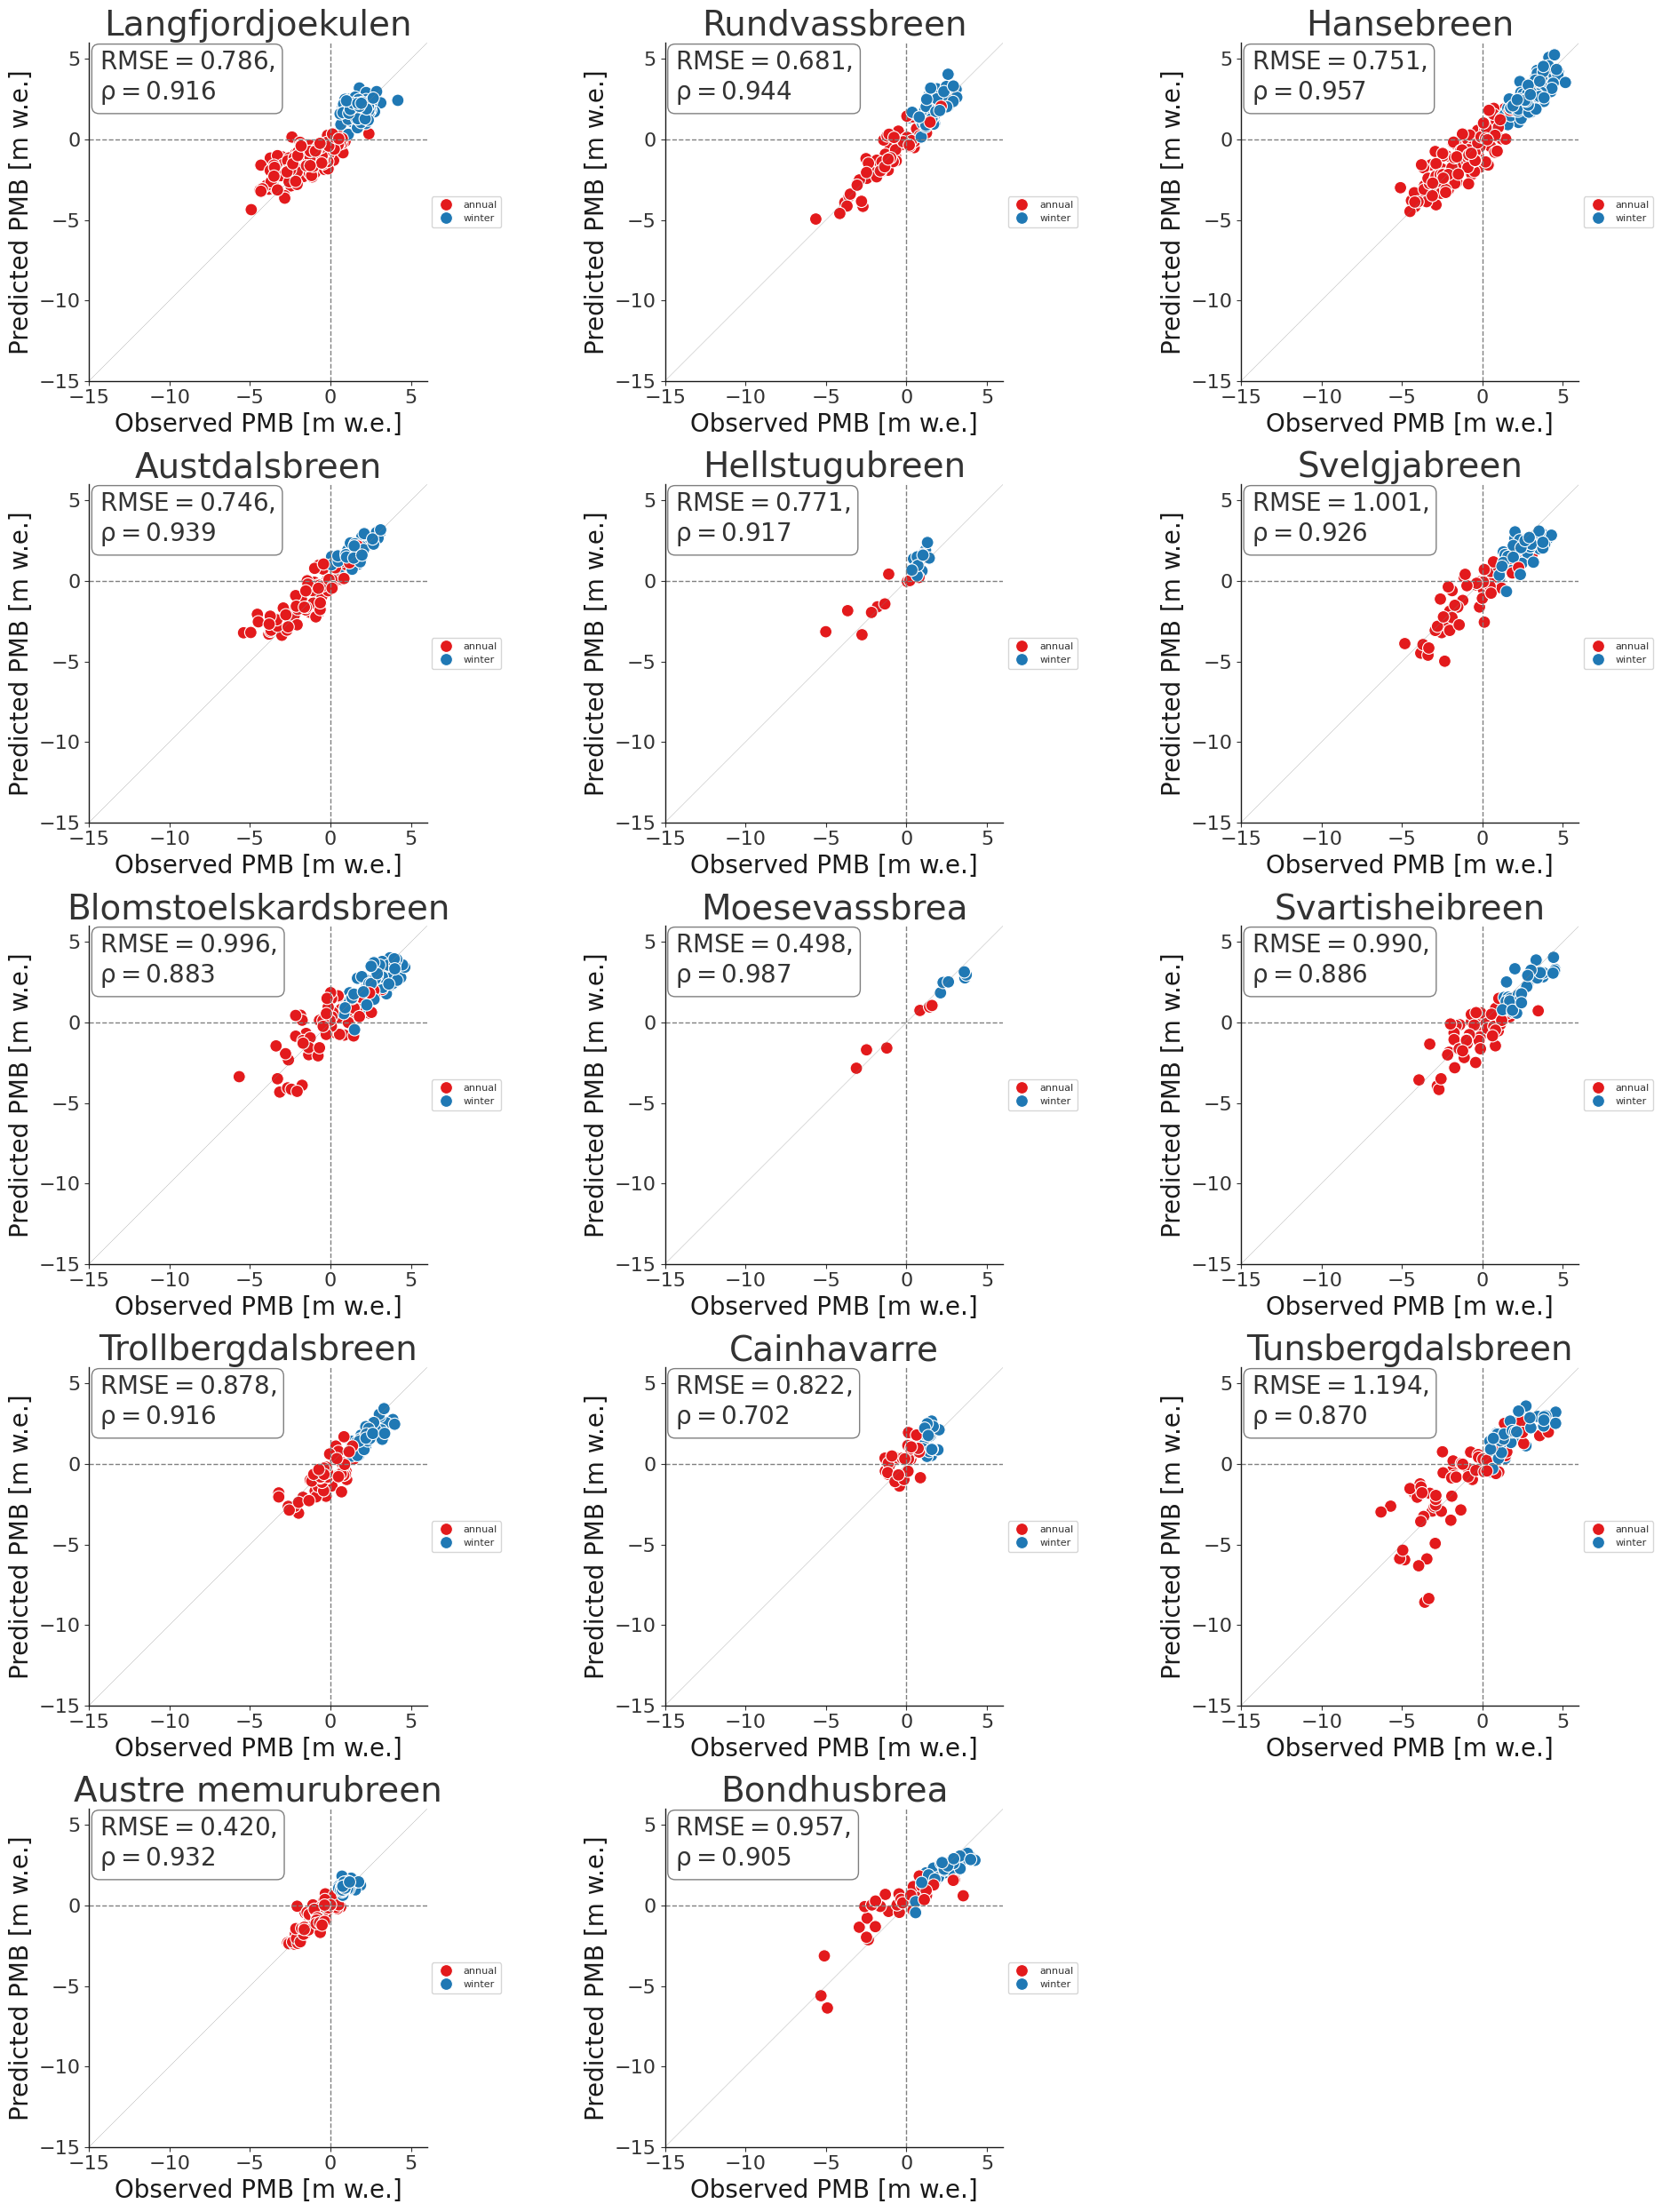

In [12]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

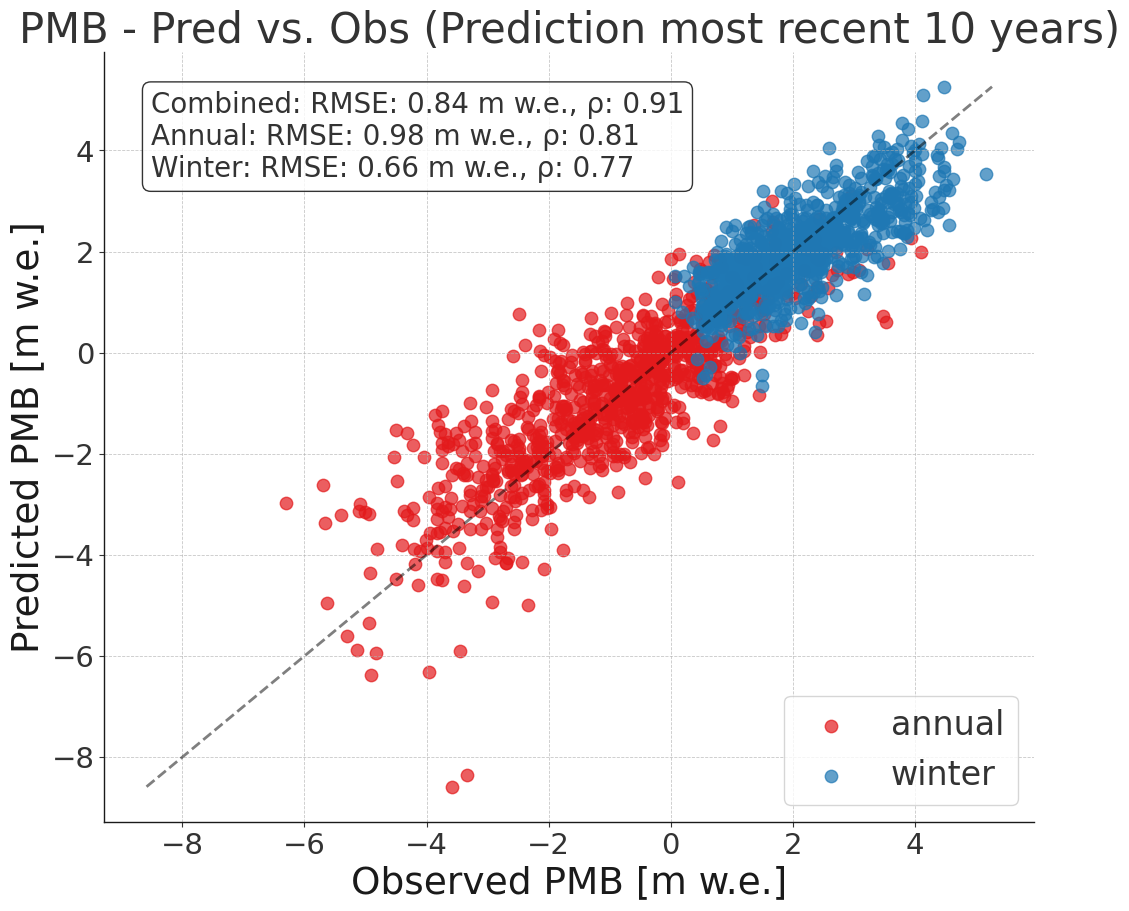

In [13]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years')

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 5)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [
    'Tunsbergdalsbreen_1966_annual_61.55016_7.13566_N_N_2897',
    'Hansebreen_2013_winter_61.75438_5.68309_N_N_5504',
    'Blomstoelskardsbreen_2013_annual_59.9842_6.36128_N_N_3840',
    'Blomstoelskardsbreen_2013_annual_59.93789_6.34729_N_N_3906'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly,
    vois_climate=vois_climate,
    vois_units=vois_units
)



### B.1. Train CH Test FR

###### Load CH galciers and merge with NOR

In [14]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  \
0      70.12589   21.77702              471   20120925  20131107   
1      70.12521   21.76711              540   20120925  20131107   
2      70.12526   21.75670              629   20120925  20131107   
3      70.12855   21.74060              722   20120925  20131107   
4      70.12529   21.71829              884   20120925  20131107   
...         ...        ...              ...        ...       ...   
6270   61.69387    7.11652             1579   19611001  19620513   
6271   70.12528   21.71827              871   20190927  20200526   
6272   68.33479   17.85005             1092   19661020  19670520   
6273   61.71461    7.11601             1587   19631001  19640507   
6274   61.57329    8.44438             1586   20100928  20110505   

      POINT_BALANCE  PERIOD           RGIId  YEAR            GLACIER  \
0             -4.92  annual  RGI60-08.01258  2013  Langfjordjoekulen   
1             -3.83  annual  RGI60-08.01258  2013  Langfjordjoekulen   
2             -3.56  annual  RGI60-08.01258  2013  Langfjordjoekulen   
3             -2.48  annual  RGI60-08.01258  2013  Langfjordjoekulen   
4             -2.57  annual  RGI60-08.01258  2013  Langfjordjoekulen   
...             ...     ...             ...   ...                ...   
6270           2.76  winter  RGI60-08.01126  1962       Nigardsbreen   
6271           2.66  winter  RGI60-08.01258  2020  Langfjordjoekulen   
6272           1.86  winter  RGI60-08.02436  1967           Blaaisen   
6273           2.01  winter  RGI60-08.01126  1964       Nigardsbreen   
6274           0.34  winter  RGI60-08.00449  2011     Hellstugubreen   

                                      DATA_MODIFICATION  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
6270  Filled missing FROM_DATE with October 1st of p...   
6271                                                NaN   
6272                                                NaN   
6273                                                NaN   
6274                                                NaN   

                                               POINT_ID      aspect  \
0     Langfjordjoekulen_2013_annual_70.12589_21.7770...   36.073272   
1     Langfjordjoekulen_2013_annual_70.12521_21.7671...   65.884818   
2     Langfjordjoekulen_2013_annual_70.12526_21.7567...   48.485310   
3     Langfjordjoekulen_2013_annual_70.12855_21.7406...   92.898660   
4     Langfjordjoekulen_2013_annual_70.12529_21.7182...  153.065195   
...                                                 ...         ...   
6270  Nigardsbreen_1962_winter_61.69387_7.11652_N_N_...   81.210212   
6271  Langfjordjoekulen_2020_winter_70.12528_21.7182...  153.065195   
6272    Blaaisen_1967_winter_68.33479_17.85005_N_N_4155   29.882699   
6273  Nigardsbreen_1964_winter_61.71461_7.11601_N_N_...  151.305943   
6274  Hellstugubreen_2011_winter_61.57329_8.44438_N_...  351.560191   

          slope         topo  hugonnet_dhdt  consensus_ice_thickness  
0     15.972541   425.458893      -3.314563                96.980293  
1     12.091276   523.195557      -2.681456               100.969521  
2     23.794335   618.154175      -1.186367                52.185333  
3      6.155833   713.652710      -1.158464               130.218109  
4      2.892178   876.630798      -1.057876                76.528084  
...         ...          ...            ...                      ...  
6270  13.313894  1570.454346      -0.178745               125.875511  
6271   2.892178   876.630798      -1.057876                76.528084  
6272  17.255500  1050.585938      -1.058776                36.787617  
6273   4.883604  1586.242676      -1.184982         

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702            471.0   20120925  20131107          -4.92   
1   70.12521   21.76711            540.0   20120925  20131107          -3.83   

   PERIOD           RGIId  YEAR            GLACIER DATA_MODIFICATION  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen               NaN   
1  annual  RGI60-08.01258  2013  Langfjordjoekulen               NaN   

                                            POINT_ID     aspect      slope  \
0  Langfjordjoekulen_2013_annual_70.12589_21.7770...  36.073272  15.972541   
1  Langfjordjoekulen_2013_annual_70.12521_21.7671...  65.884818  12.091276   

         topo  hugonnet_dhdt  consensus_ice_thickness  
0  425.458893      -3.314563                96.980293  
1  523.195557      -2.681456               100.969521

71

In [15]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

2025-06-17 13:03:26,550 - INFO - Number of annual and seasonal samples: 39633
2025-06-17 13:03:26,554 - INFO - Running on 71 glaciers:
['Langfjordjoekulen' 'Rundvassbreen' 'Engabreen' 'Aalfotbreen'
 'Hansebreen' 'Nigardsbreen' 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen'
 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memurubreen'
 'Vestre Memurubreen' 'Hoegtuvbreen' 'Bondhusbrea' 'adler' 'albigna'
 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden'
 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner'
 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar'
 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexr

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2013   21.77702   70.12589          -4.92        341.344485   
1  2013   21.77702   70.12589          -4.92        341.344485   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            129.655515            471.0  RGI60-08.01258   
1            129.655515            471.0  RGI60-08.01258   

                                            POINT_ID  ID  ...  \
0  Langfjordjoekulen_2013_annual_70.12589_21.7770...   0  ...   
1  Langfjordjoekulen_2013_annual_70.12589_21.7770...   0  ...   

   consensus_ice_thickness       t2m        tp      slhf      sshf       ssrd  \
0                96.980293 -0.428070  0.003846  -55354.0  657502.0  2040907.0   
1                96.980293 -4.780853  0.003902  178386.0  909366.0   157664.0   

        fal        str       u10       v10  
0  0.439741 -2504336.0 -0.141248  0.397857  
1  0.817481 -1714196.0 -0.183276  1.758524  

[2 rows x 27 columns]

In [16]:
test_glaciers = list(data_NOR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


Size of test data: 60056
Size of train data: 290682
Percentage of test size: 20.66%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (32) ['Langfjordjoekulen' 'Rundvassbreen' 'Engabreen' 'Aalfotbreen'
 'Hansebreen' 'Nigardsbreen' 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen'
 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledal

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### B.2.2. XGBoost Transfer Region

In [17]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

#### Grid Search

In [18]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_11_06_NOR.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_11_06_NOR.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 25)
Shape of testing dataset: (60056, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.1944065965918095
Shape of the test: (60056, 14)
Overall score: 2.9458274369953625
CPU times: user 384 ms, sys: 101 ms, total: 485 ms
Wall time: 278 ms


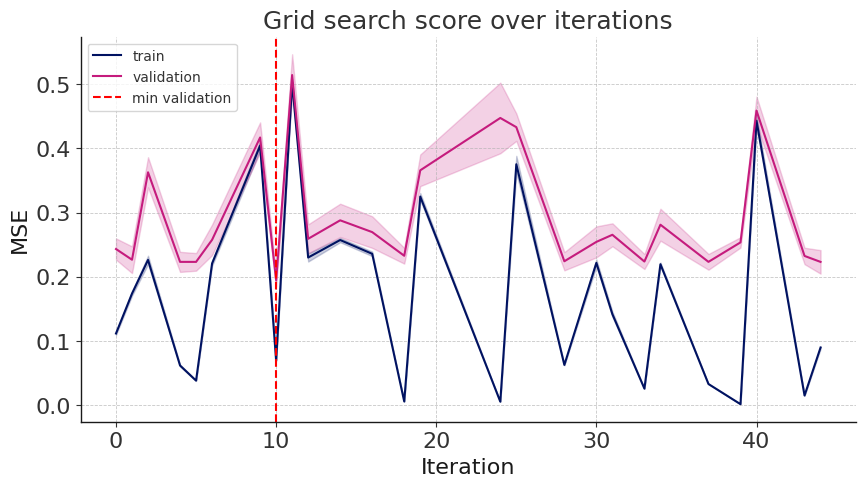

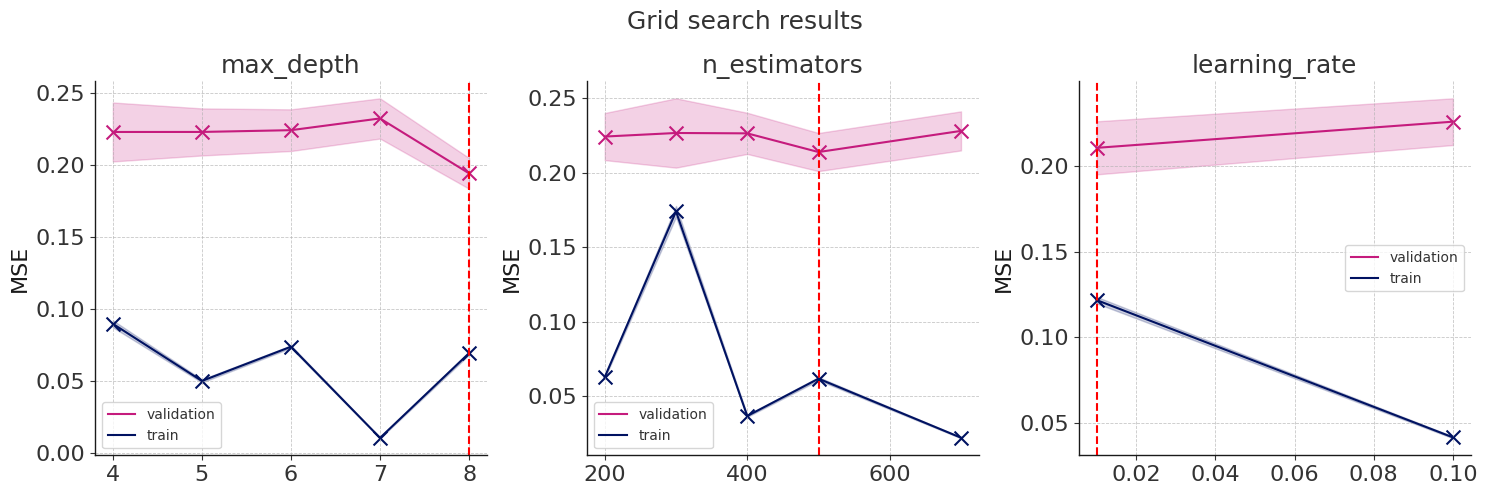

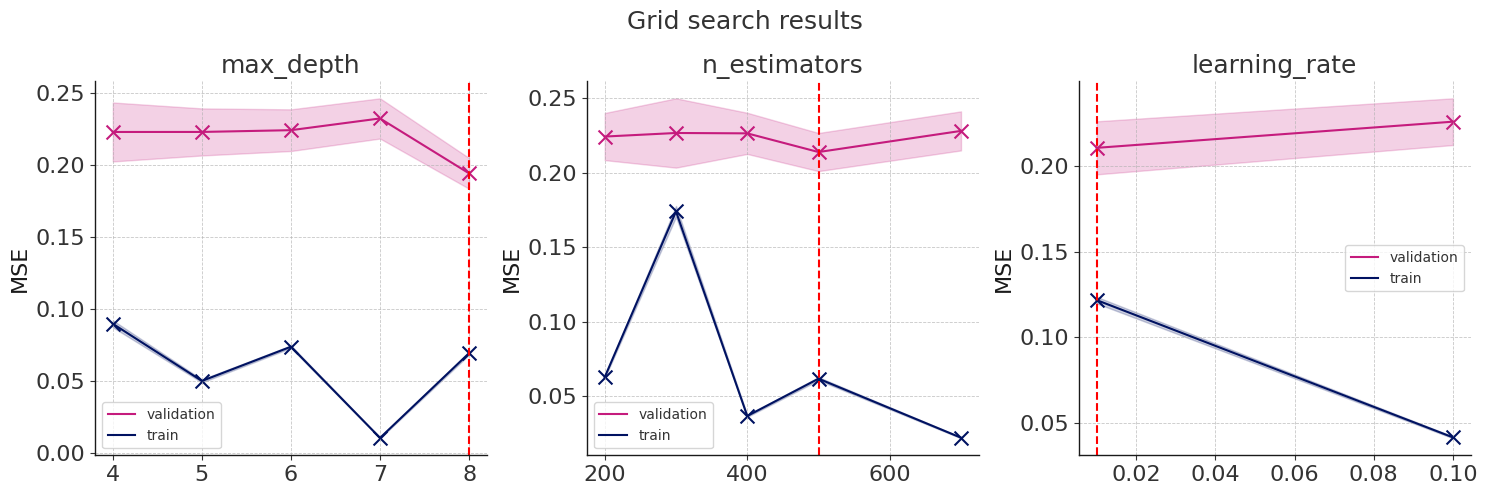

In [19]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

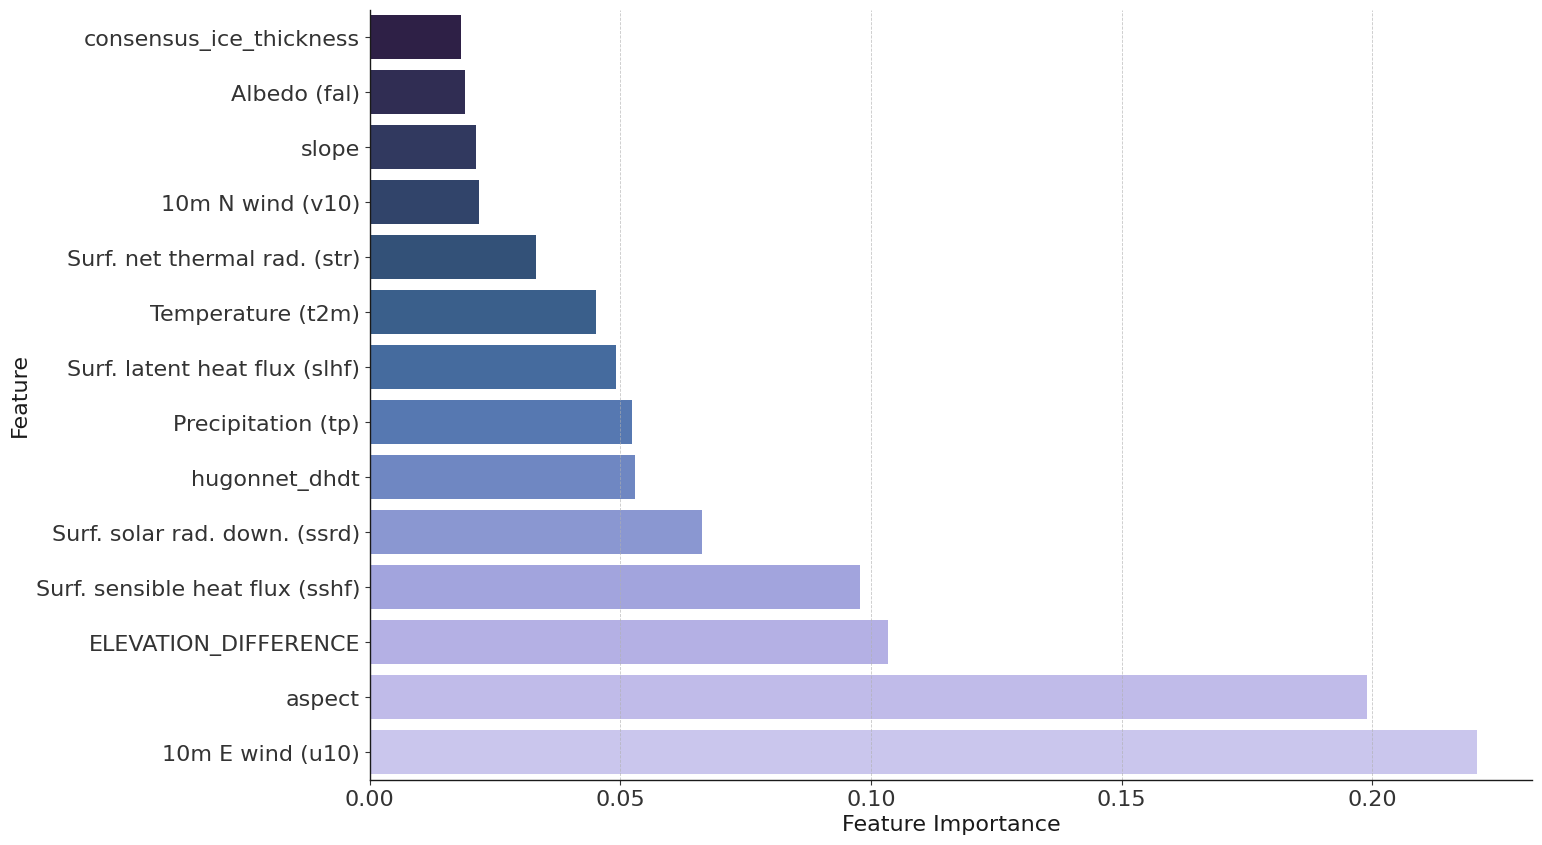

In [20]:
FIPlot(best_estimator, feature_columns, vois_climate)

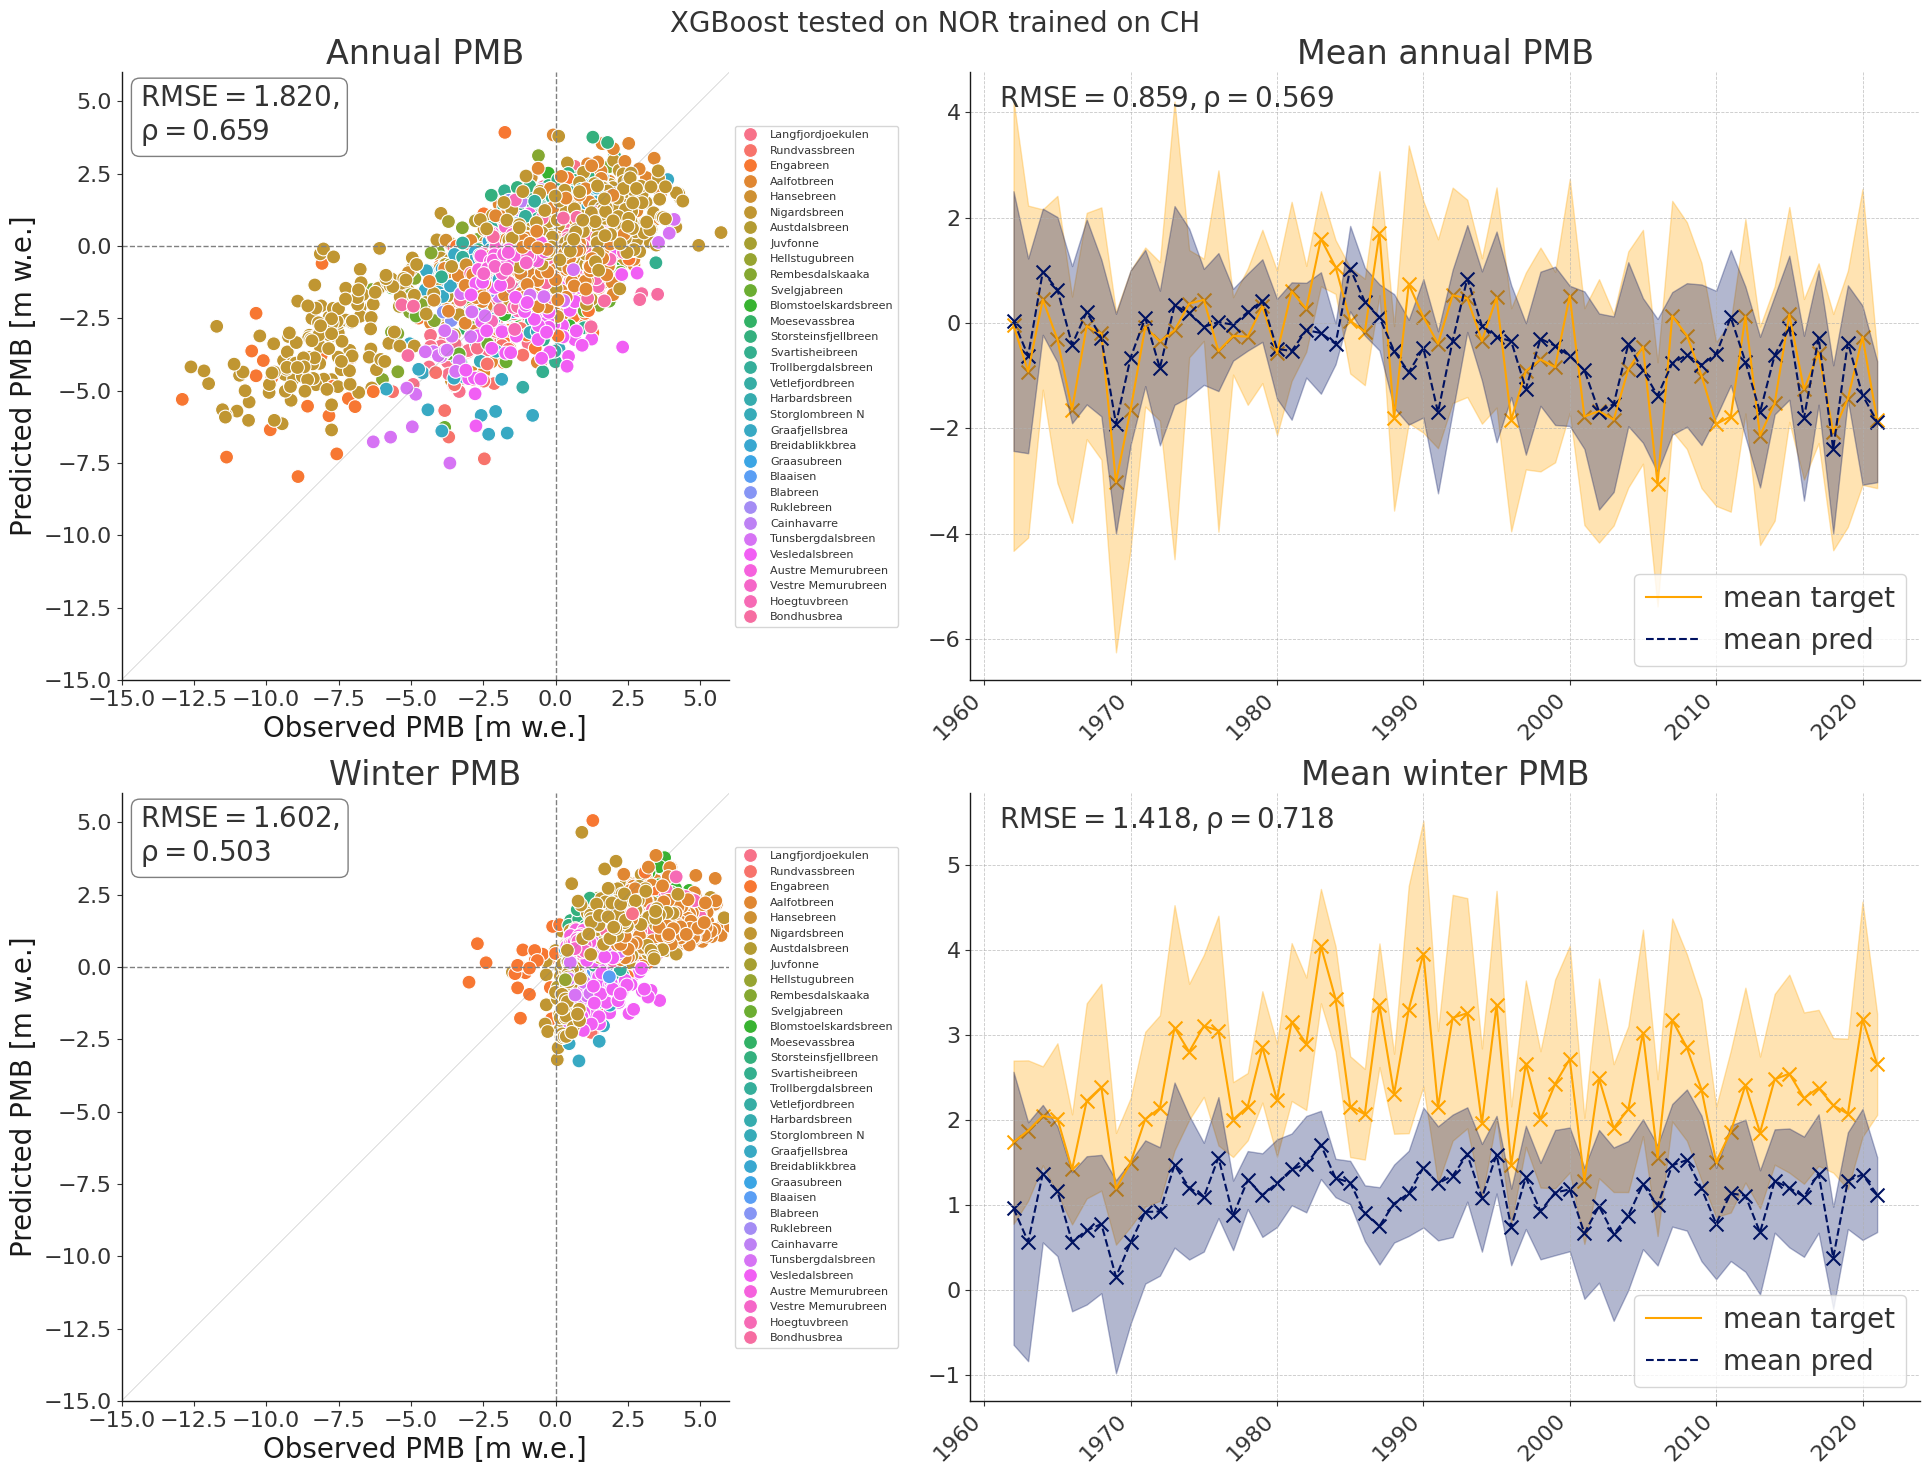

In [21]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on NOR trained on CH', fontsize=20)
plt.tight_layout()

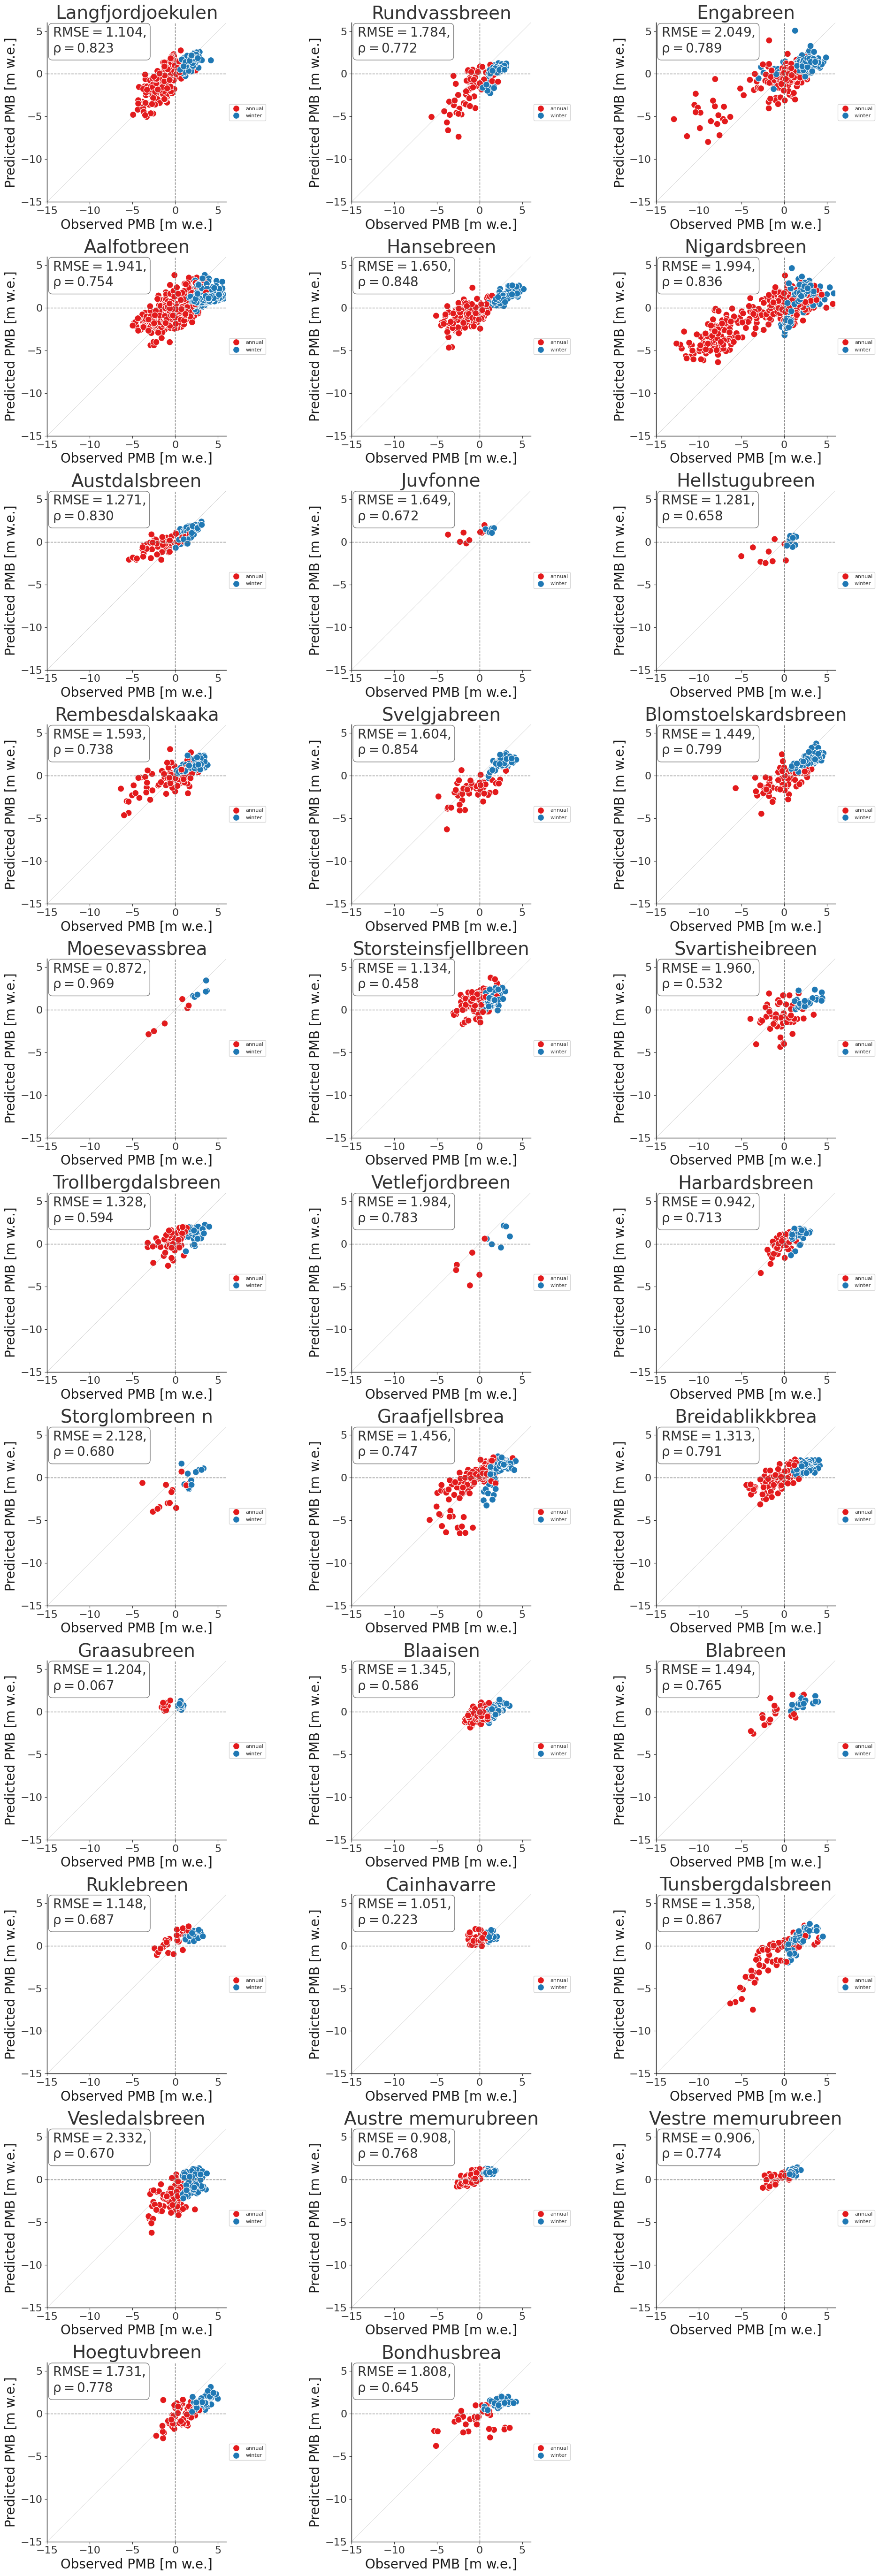

In [22]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

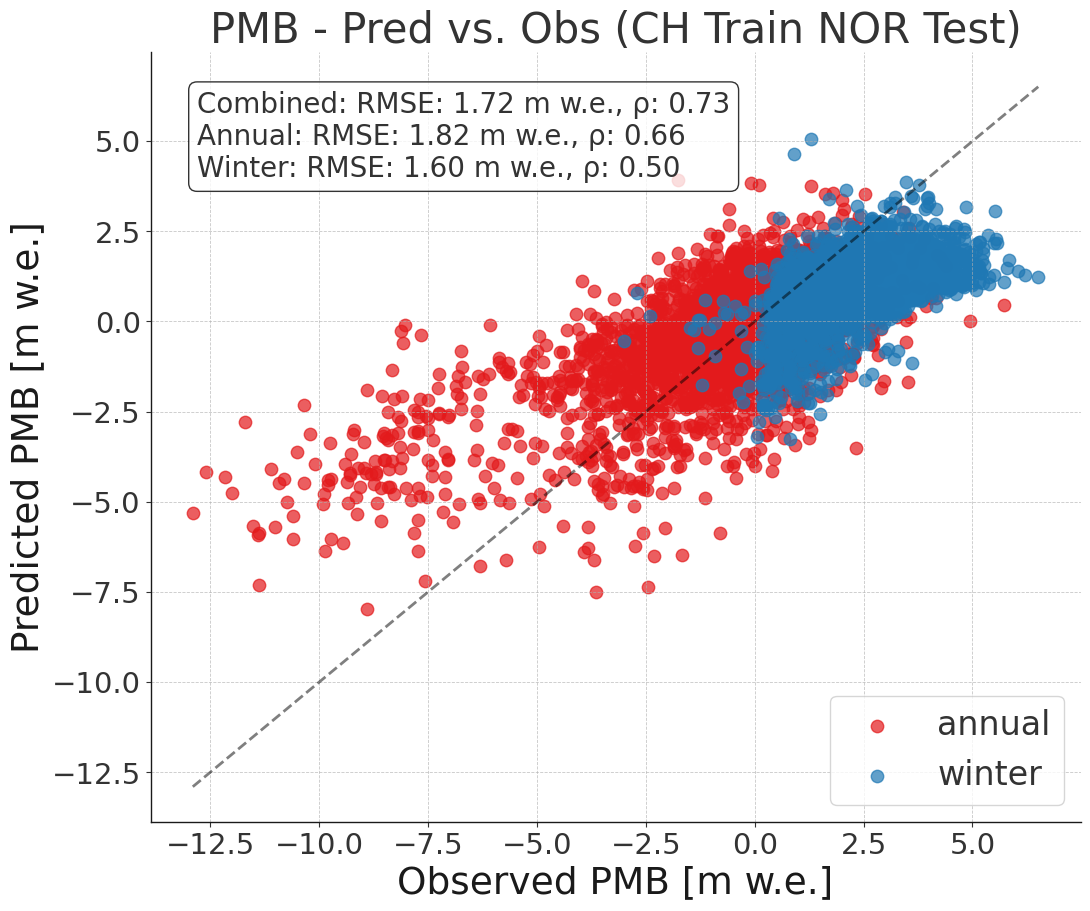

In [23]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train NOR Test', include_summer = False)

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 1)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [
    'Tunsbergdalsbreen_1966_annual_61.55016_7.13566_N_N_2897',
    'Hansebreen_2013_winter_61.75438_5.68309_N_N_5504',
    'Blomstoelskardsbreen_2013_annual_59.9842_6.36128_N_N_3840',
    'Blomstoelskardsbreen_2013_annual_59.93789_6.34729_N_N_3906'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly_CH_NOR,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### Predictions of custom parameters:

Shape of training dataset: (290682, 25)
Shape of testing dataset: (60056, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': 4, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
Shape of the test: (60056, 14)
Overall score: 2.336449650509373


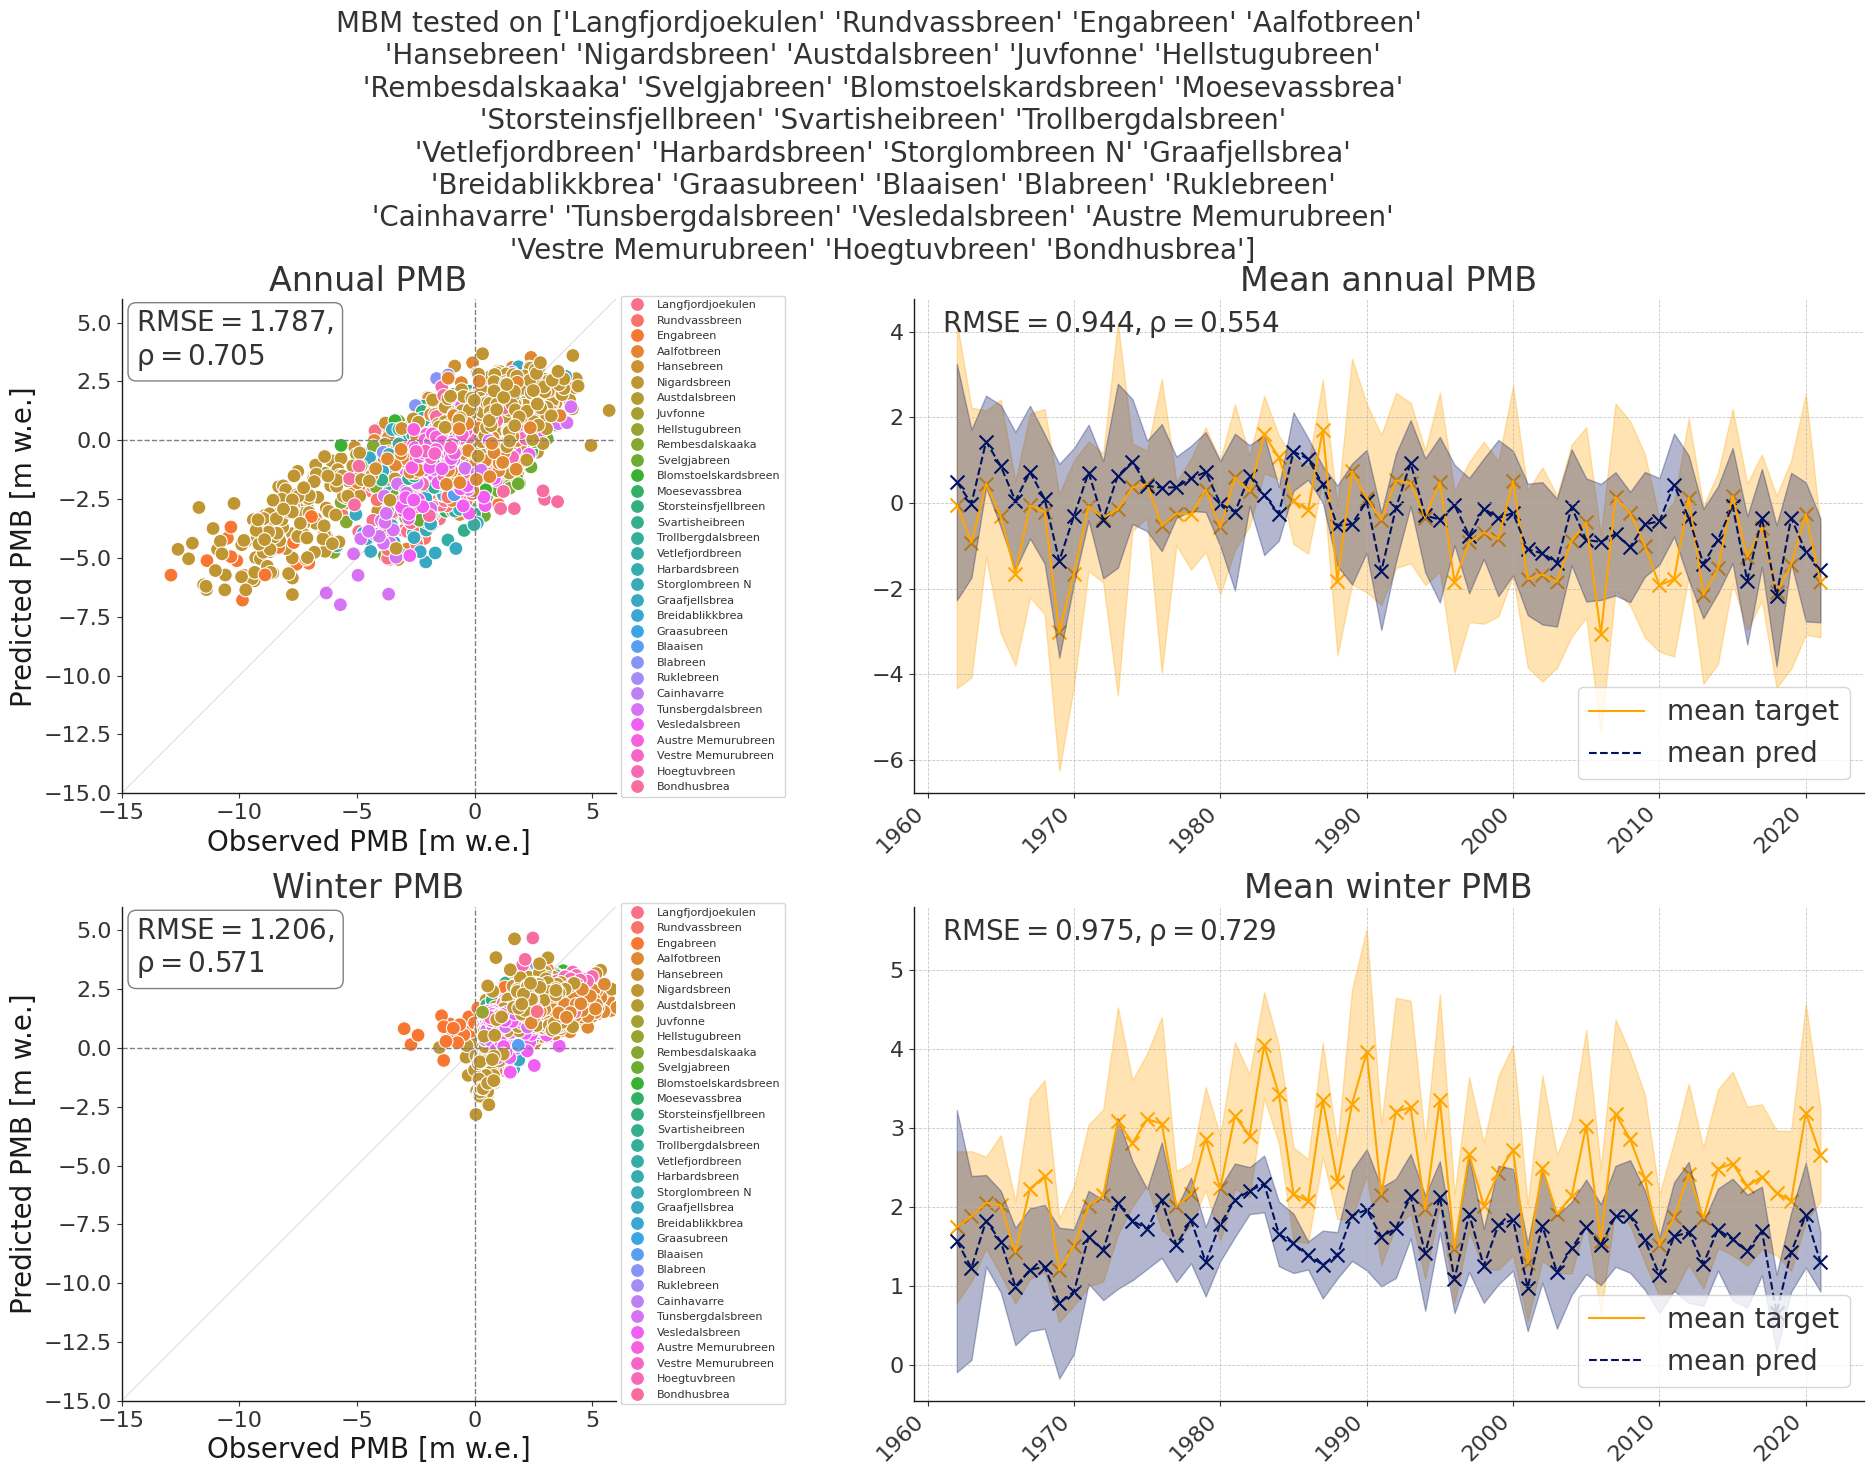

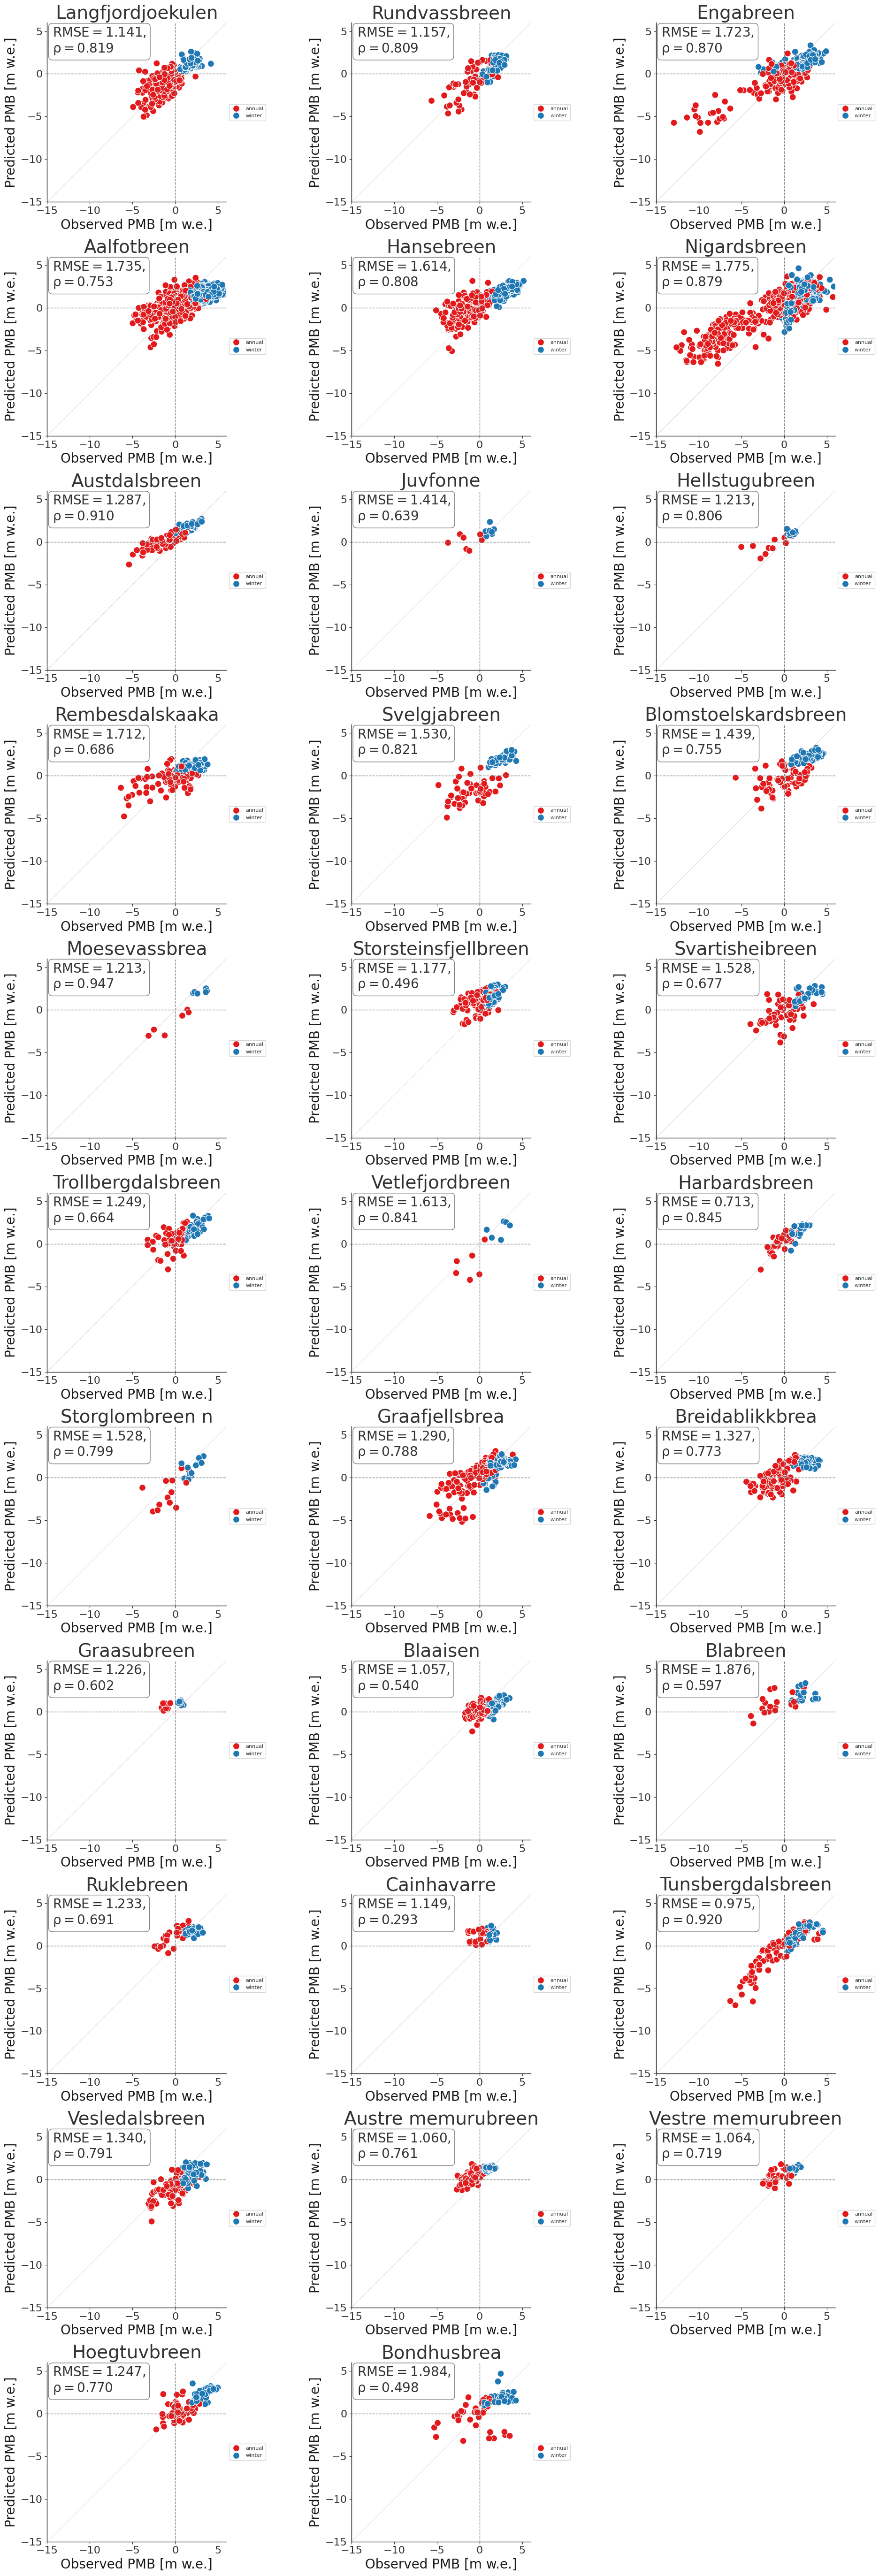

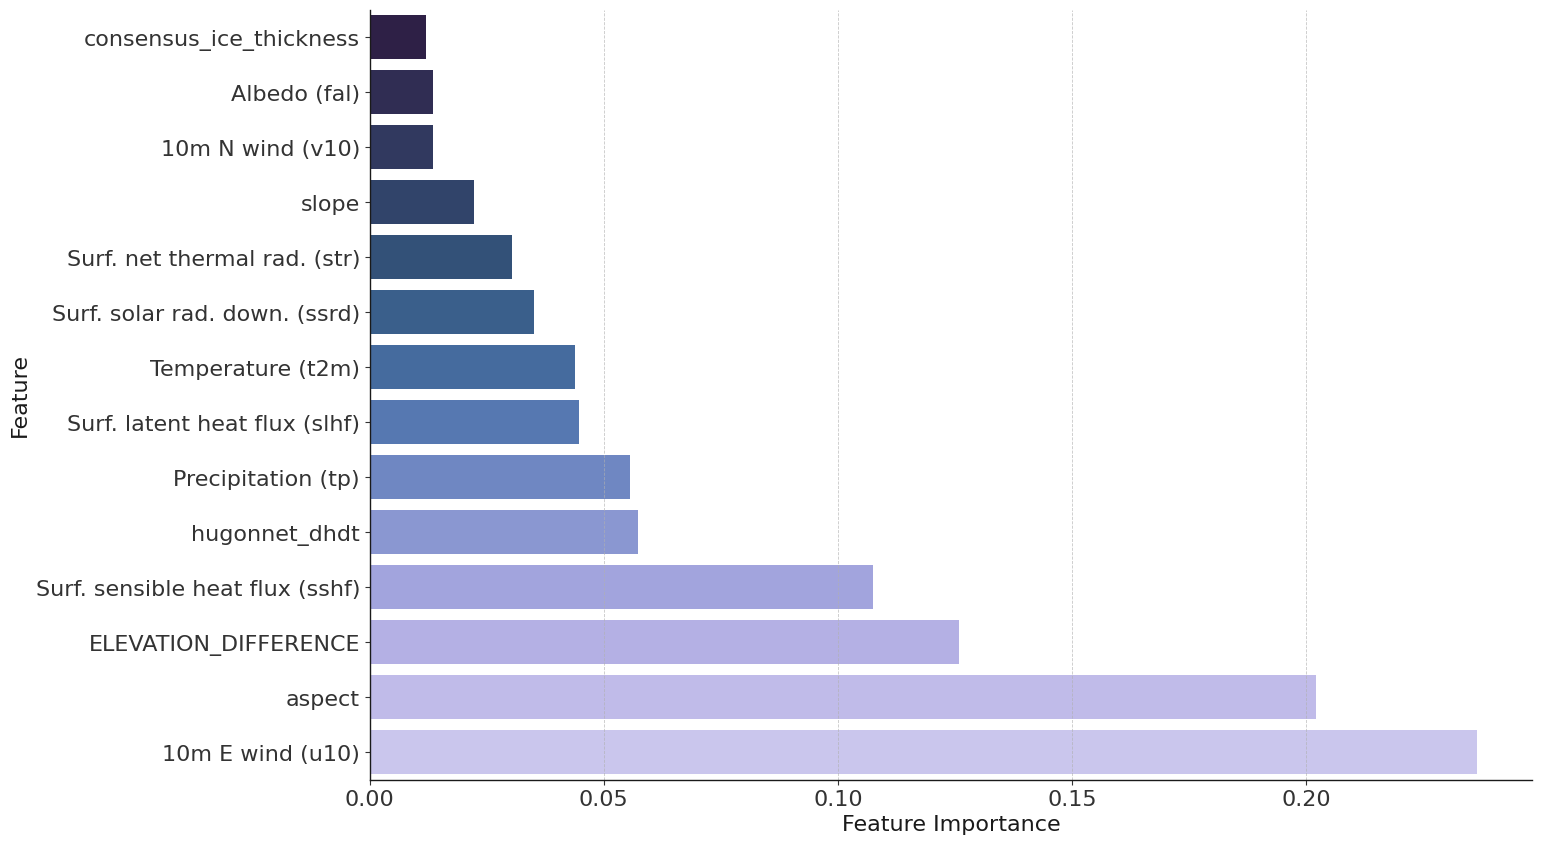

In [24]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)